# RQ6: Agency and directionality analysis

This notebook examines who is positioned as acting on AI versus who is affected by it. We analyse whether parliamentary discourse positions the state as governing AI (active agency) or people as being affected by AI (passive agency), comparing motioner against propositioner.

## Setup and imports

In [1]:
import re
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from scipy import stats

In [2]:
# visualisation settings
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# purple/pink colour palette
COLOUR_MOT = '#9B59B6'
COLOUR_PROP = '#E91E63'
COLOUR_GOVERNING = '#8E44AD'
COLOUR_AFFECTED = '#E74C3C'

## Data loading

In [3]:
def parse_document(file_path):
    """extract metadata and content from document file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # split metadata from content
    parts = content.split('=' * 80, 1)
    if len(parts) != 2:
        return None
    
    metadata_section, html_content = parts
    
    # extract metadata fields
    metadata = {}
    for line in metadata_section.strip().split('\n'):
        if ':' in line:
            key, value = line.split(':', 1)
            metadata[key.strip()] = value.strip()
    
    # extract plain text from html
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    
    # clean text
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'Observera att dokumentet är inskannat.*?förekomma\.?', '', text, flags=re.IGNORECASE)
    
    return {
        'doc_id': metadata.get('DOCUMENT ID', ''),
        'title': metadata.get('TITLE', ''),
        'date': metadata.get('DATE', ''),
        'parl_year': metadata.get('PARLIAMENTARY YEAR', ''),
        'text': text.strip(),
        'char_count': len(text)
    }

In [4]:
# load motioner
data_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data')
motioner_dir = data_dir / 'motioner'
propositioner_dir = data_dir / 'propositioner'

documents = []

for file_path in motioner_dir.glob('*.txt'):
    doc = parse_document(file_path)
    if doc and doc['char_count'] > 100:
        doc['doc_type'] = 'mot'
        documents.append(doc)

for file_path in propositioner_dir.glob('*.txt'):
    doc = parse_document(file_path)
    if doc and doc['char_count'] > 100:
        doc['doc_type'] = 'prop'
        documents.append(doc)

df = pd.DataFrame(documents)
print(f"loaded {len(df)} documents")
print(f"  motioner: {len(df[df['doc_type'] == 'mot'])}")
print(f"  propositioner: {len(df[df['doc_type'] == 'prop'])}")

loaded 1152 documents
  motioner: 452
  propositioner: 700


## Agency keyword dictionaries

In [5]:
# governing agency - state acts ON ai
governing_keywords = [
    r'\bstyra\b', r'\bstyr\b', r'\bstyrs\b', r'\bstyrt\b',
    r'\breglera\b', r'\breglerar\b', r'\breglering\b', r'\bregleringar\b',
    r'\bkontrollera\b', r'\bkontroller\b', r'\bkontroll\b',
    r'\bövervaka\b', r'\bövervakar\b', r'\bövervakning\b',
    r'\blagstifta\b', r'\blagstiftning\b',
    r'\bimplementera\b', r'\bimplementering\b',
    r'\bsäkerställa\b', r'\bsäkerställer\b',
    r'\bkräva\b', r'\bkräver\b', r'\bkrav\b',
    r'\bförbjuda\b', r'\bförbjuder\b', r'\bförbud\b',
    r'\bbegränsa\b', r'\bbegränsar\b', r'\bbegränsning\b',
    r'\btillåta\b', r'\btillåter\b',
    r'\bbestämma\b', r'\bbestämmer\b'
]

# affected agency - people affected BY ai
affected_keywords = [
    r'\bdrabbas\b', r'\bdrabba\b', r'\bdrabbade\b',
    r'\bpåverkas\b', r'\bpåverka\b', r'\bpåverkan\b',
    r'\butsättas\b', r'\butsatt\b', r'\butsatta\b',
    r'\bhotas\b', r'\bhota\b', r'\bhot\b',
    r'\bersättas\b', r'\bersätta\b', r'\bersättning\b',
    r'\bförlorar\b', r'\bförlora\b', r'\bförlust\b',
    r'\briskera\b', r'\briskerar\b', r'\brisk\b', r'\brisker\b',
    r'\btvingas\b', r'\btvinga\b', r'\btvång\b',
    r'\banpassas\b', r'\banpassa\b', r'\banpassning\b',
    r'\bberoende\b', r'\bberor\b'
]

# compile regex patterns
governing_pattern = re.compile('|'.join(governing_keywords), re.IGNORECASE)
affected_pattern = re.compile('|'.join(affected_keywords), re.IGNORECASE)

print(f"governing agency keywords: {len(governing_keywords)}")
print(f"affected agency keywords: {len(affected_keywords)}")

governing agency keywords: 33
affected agency keywords: 30


## Context extraction

In [6]:
# ai search patterns
ai_patterns = [
    r'\bai\b',
    r'artificiell intelligens',
    r'maskininlärning',
    r'maskinlärning',
    r'djupinlärning'
]

ai_regex = re.compile('|'.join(ai_patterns), re.IGNORECASE)

In [7]:
def extract_ai_contexts(text, window=100):
    """extract text windows around ai mentions."""
    contexts = []
    
    for match in ai_regex.finditer(text):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        contexts.append(context)
    
    return contexts

In [8]:
# extract contexts for all documents
df['ai_contexts'] = df['text'].apply(extract_ai_contexts)
df['ai_mention_count'] = df['ai_contexts'].apply(len)
df['combined_context'] = df['ai_contexts'].apply(lambda x: ' '.join(x))
df['context_length'] = df['combined_context'].apply(len)

# filter to documents with ai mentions
df_with_ai = df[df['ai_mention_count'] > 0].copy()

print(f"total ai mentions: {df['ai_mention_count'].sum()}")
print(f"documents with ai mentions: {len(df_with_ai)}")
print(f"  motioner: {len(df_with_ai[df_with_ai['doc_type'] == 'mot'])}")
print(f"  propositioner: {len(df_with_ai[df_with_ai['doc_type'] == 'prop'])}")

total ai mentions: 4557
documents with ai mentions: 706
  motioner: 444
  propositioner: 262


## Agency scoring

In [9]:
def count_agency_keywords(text, pattern):
    """count keyword matches in text."""
    matches = pattern.findall(text)
    return len(matches)

In [10]:
# count governing and affected keywords in contexts
df_with_ai['governing_count'] = df_with_ai['combined_context'].apply(
    lambda x: count_agency_keywords(x, governing_pattern)
)
df_with_ai['affected_count'] = df_with_ai['combined_context'].apply(
    lambda x: count_agency_keywords(x, affected_pattern)
)

# normalise per 1000 characters
df_with_ai['governing_norm'] = (df_with_ai['governing_count'] / (df_with_ai['context_length'] + 1)) * 1000
df_with_ai['affected_norm'] = (df_with_ai['affected_count'] / (df_with_ai['context_length'] + 1)) * 1000

# calculate agency ratio (positive = more governing, negative = more affected)
df_with_ai['agency_ratio'] = df_with_ai['governing_norm'] - df_with_ai['affected_norm']

print("agency scoring complete")
print(f"\nmean governing mentions per 1k chars: {df_with_ai['governing_norm'].mean():.2f}")
print(f"mean affected mentions per 1k chars: {df_with_ai['affected_norm'].mean():.2f}")
print(f"mean agency ratio: {df_with_ai['agency_ratio'].mean():.2f}")

agency scoring complete

mean governing mentions per 1k chars: 0.40
mean affected mentions per 1k chars: 0.37
mean agency ratio: 0.03


## Comparison by document type

In [11]:
# summary statistics by document type
summary_stats = df_with_ai.groupby('doc_type')[[
    'governing_norm', 'affected_norm', 'agency_ratio'
]].agg(['mean', 'median', 'std']).round(2)

print("agency statistics by document type:")
print(summary_stats)

agency statistics by document type:
         governing_norm              affected_norm              agency_ratio  \
                   mean median   std          mean median   std         mean   
doc_type                                                                       
mot                0.49    0.0  1.08          0.49    0.0  1.15         0.00   
prop               0.26    0.0  0.96          0.18    0.0  0.63         0.07   

                       
         median   std  
doc_type               
mot         0.0  1.54  
prop        0.0  1.14  


In [12]:
# statistical comparison
mot_data = df_with_ai[df_with_ai['doc_type'] == 'mot']
prop_data = df_with_ai[df_with_ai['doc_type'] == 'prop']

print("\nstatistical tests (mann-whitney u):")

for metric in ['governing_norm', 'affected_norm', 'agency_ratio']:
    mot_vals = mot_data[metric]
    prop_vals = prop_data[metric]
    
    stat, pval = stats.mannwhitneyu(mot_vals, prop_vals, alternative='two-sided')
    mean_diff = mot_vals.mean() - prop_vals.mean()
    
    print(f"\n{metric}:")
    print(f"  motioner mean: {mot_vals.mean():.2f}")
    print(f"  propositioner mean: {prop_vals.mean():.2f}")
    print(f"  difference: {mean_diff:.2f}")
    print(f"  p-value: {pval:.4f}")


statistical tests (mann-whitney u):

governing_norm:
  motioner mean: 0.49
  propositioner mean: 0.26
  difference: 0.23
  p-value: 0.0000

affected_norm:
  motioner mean: 0.49
  propositioner mean: 0.18
  difference: 0.30
  p-value: 0.0000

agency_ratio:
  motioner mean: 0.00
  propositioner mean: 0.07
  difference: -0.07
  p-value: 0.7819


## Temporal analysis

In [13]:
# clean parliamentary year
df_with_ai['year_clean'] = df_with_ai['parl_year'].str.split('/').str[0]
df_with_ai['year_clean'] = pd.to_numeric(df_with_ai['year_clean'], errors='coerce')

# filter to valid years from 2017 onwards
df_temporal = df_with_ai[df_with_ai['year_clean'] >= 2017].copy()

# group by year and document type
temporal_agency = df_temporal.groupby(['year_clean', 'doc_type']).agg({
    'governing_norm': 'mean',
    'affected_norm': 'mean',
    'agency_ratio': 'mean',
    'doc_id': 'count'
}).reset_index()
temporal_agency.columns = ['year', 'doc_type', 'mean_governing', 'mean_affected', 'mean_agency_ratio', 'doc_count']

print(f"temporal data from {df_temporal['year_clean'].min():.0f} to {df_temporal['year_clean'].max():.0f}")
print(f"documents in temporal analysis: {len(df_temporal)}")

temporal data from 2017 to 2025
documents in temporal analysis: 607


## Visualisations

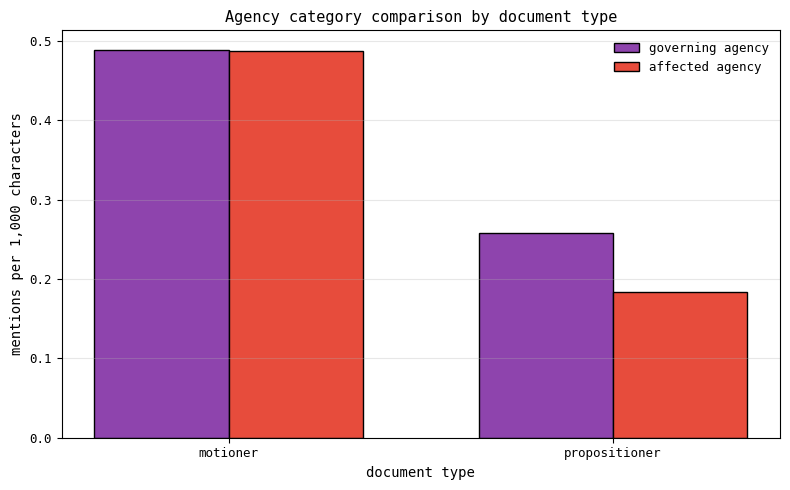

In [14]:
# bar chart comparing agency categories by document type
fig, ax = plt.subplots(figsize=(8, 5))

means_by_type = df_with_ai.groupby('doc_type')[['governing_norm', 'affected_norm']].mean()

x = np.arange(len(means_by_type.index))
width = 0.35

ax.bar(x - width/2, means_by_type['governing_norm'], width, 
       label='governing agency', color=COLOUR_GOVERNING, edgecolor='black')
ax.bar(x + width/2, means_by_type['affected_norm'], width,
       label='affected agency', color=COLOUR_AFFECTED, edgecolor='black')

ax.set_xlabel('document type')
ax.set_ylabel('mentions per 1,000 characters')
ax.set_title('Agency category comparison by document type')
ax.set_xticks(x)
ax.set_xticklabels(['motioner', 'propositioner'])
ax.legend(frameon=False)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq6_agency_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

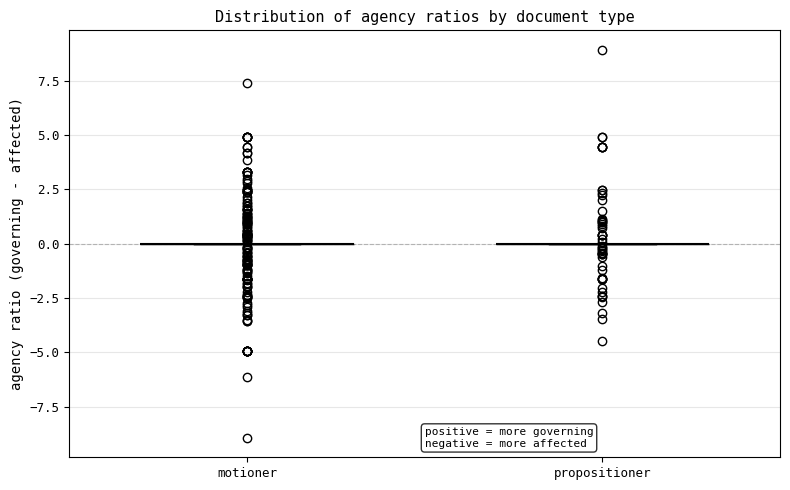

In [15]:
# box plot of agency ratio distribution
fig, ax = plt.subplots(figsize=(8, 5))

mot_ratio = df_with_ai[df_with_ai['doc_type'] == 'mot']['agency_ratio']
prop_ratio = df_with_ai[df_with_ai['doc_type'] == 'prop']['agency_ratio']

positions = [1, 2]
bp = ax.boxplot(
    [mot_ratio, prop_ratio],
    positions=positions,
    widths=0.6,
    patch_artist=True,
    medianprops={'color': 'black', 'linewidth': 1.5},
    boxprops={'edgecolor': 'black'},
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'}
)

bp['boxes'][0].set_facecolor(COLOUR_MOT)
bp['boxes'][1].set_facecolor(COLOUR_PROP)

ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.8, alpha=0.5, label='neutral')
ax.set_xticks(positions)
ax.set_xticklabels(['motioner', 'propositioner'])
ax.set_ylabel('agency ratio (governing - affected)')
ax.set_title('Distribution of agency ratios by document type')
ax.grid(axis='y', alpha=0.3)

# add text annotation
ax.text(0.5, 0.02, 'positive = more governing\nnegative = more affected', 
        transform=ax.transAxes, fontsize=8, ha='left', va='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq6_agency_boxplot.png',
            dpi=300, bbox_inches='tight')
plt.show()

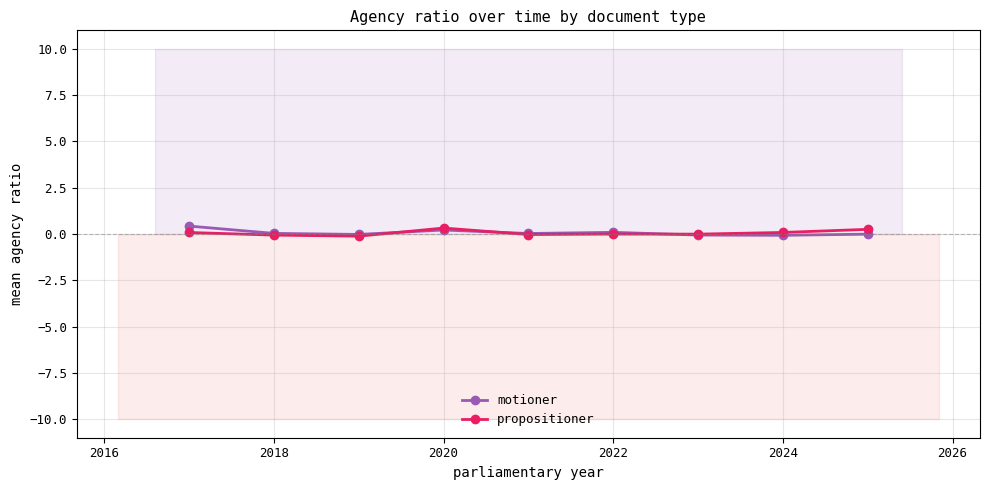

In [16]:
# temporal line chart
fig, ax = plt.subplots(figsize=(10, 5))

for doc_type, colour, label in [('mot', COLOUR_MOT, 'motioner'), ('prop', COLOUR_PROP, 'propositioner')]:
    data = temporal_agency[temporal_agency['doc_type'] == doc_type]
    ax.plot(data['year'], data['mean_agency_ratio'],
            marker='o', color=colour, linewidth=2, markersize=6,
            label=label)

ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('parliamentary year')
ax.set_ylabel('mean agency ratio')
ax.set_title('Agency ratio over time by document type')
ax.legend(frameon=False)
ax.grid(alpha=0.3)

# add shaded region for interpretation
ax.fill_between(ax.get_xlim(), 0, 10, alpha=0.1, color=COLOUR_GOVERNING, label='_nolegend_')
ax.fill_between(ax.get_xlim(), -10, 0, alpha=0.1, color=COLOUR_AFFECTED, label='_nolegend_')

plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq6_agency_temporal.png',
            dpi=300, bbox_inches='tight')
plt.show()

## Export results

In [17]:
# create results directory
results_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results')
results_dir.mkdir(exist_ok=True)

In [18]:
# export document-level data
export_cols = [
    'doc_id', 'doc_type', 'parl_year', 'title',
    'ai_mention_count', 'context_length',
    'governing_count', 'affected_count',
    'governing_norm', 'affected_norm', 'agency_ratio'
]

output_path = results_dir / 'rq6_agency.csv'
df_with_ai[export_cols].to_csv(output_path, index=False, encoding='utf-8')

print(f"exported document-level data: {len(df_with_ai)} documents")
print(f"saved to {output_path}")

exported document-level data: 706 documents
saved to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq6_agency.csv


In [19]:
# export aggregated summary
summary_export = df_with_ai.groupby('doc_type').agg({
    'doc_id': 'count',
    'ai_mention_count': 'sum',
    'governing_count': 'sum',
    'affected_count': 'sum',
    'governing_norm': ['mean', 'median', 'std'],
    'affected_norm': ['mean', 'median', 'std'],
    'agency_ratio': ['mean', 'median', 'std']
}).round(3)

summary_output = results_dir / 'rq6_agency_summary.csv'
summary_export.to_csv(summary_output, encoding='utf-8')

print(f"exported summary statistics")
print(f"saved to {summary_output}")

exported summary statistics
saved to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq6_agency_summary.csv


In [20]:
# export temporal data
temporal_output = results_dir / 'rq6_agency_temporal.csv'
temporal_agency.to_csv(temporal_output, index=False, encoding='utf-8')

print(f"exported temporal summary")
print(f"saved to {temporal_output}")

exported temporal summary
saved to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq6_agency_temporal.csv


In [21]:
# print final summary
print("\n" + "="*60)
print("RQ6 AGENCY ANALYSIS SUMMARY")
print("="*60)

print(f"\nDocuments analysed: {len(df_with_ai)}")
print(f"  Motioner: {len(df_with_ai[df_with_ai['doc_type'] == 'mot'])}")
print(f"  Propositioner: {len(df_with_ai[df_with_ai['doc_type'] == 'prop'])}")

print("\nMean agency ratio by document type:")
for doc_type in ['mot', 'prop']:
    ratio = df_with_ai[df_with_ai['doc_type'] == doc_type]['agency_ratio'].mean()
    label = 'motioner' if doc_type == 'mot' else 'propositioner'
    direction = 'governing-oriented' if ratio > 0 else 'affected-oriented'
    print(f"  {label}: {ratio:.2f} ({direction})")

print("\nInterpretation:")
print("  Positive ratio = state positioned as acting ON AI")
print("  Negative ratio = people positioned as affected BY AI")


RQ6 AGENCY ANALYSIS SUMMARY

Documents analysed: 706
  Motioner: 444
  Propositioner: 262

Mean agency ratio by document type:
  motioner: 0.00 (governing-oriented)
  propositioner: 0.07 (governing-oriented)

Interpretation:
  Positive ratio = state positioned as acting ON AI
  Negative ratio = people positioned as affected BY AI
